In [32]:
import pandas as pd
import numpy as np
import wandb
from wandb.integration.keras import WandbCallback
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import notebook_login
notebook_login()
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK KR'
import seaborn as sns

# 데이터 합치기

In [2]:
data1 = pd.read_csv('./data/train.csv', index_col = 'idx')
data2 = pd.read_csv('./data/normal_conversation.csv', index_col = 'idx')

In [3]:
data = pd.concat([data1, data2])
print(len(data1), len(data2), len(data))
data.head()

3950 997 4947


,class,conversation
idx,,
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


# 데이터 라벨링

In [4]:
label_map = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

data['class'] = data['class'].apply(lambda x: label_map[x])
data.head()

,class,conversation
idx,,
0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


# W&B 초기화

In [5]:
# wandb.init(project="dktc-text-classification")

# 데이터 전처리

In [6]:
# DistilBERT 토크나이저 로드
tokenizer = DistilBertTokenizer.from_pretrained('monologg/distilkobert')

# 데이터를 DistilBERT 입력 형식으로 변환하는 함수 정의
def convert_to_input(df, tokenizer, max_length=400):
    input_ids = []
    attention_masks = []
    labels = []

    for i in range(len(df)):
        sentence = df.iloc[i]['conversation'].replace('.', '').replace('\n', '[SEP]')
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append(df.iloc[i]['class'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }, labels

In [7]:
train_df, test_df = train_test_split(data, test_size = 0.2, random_state = 526)

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('monologg/distilkobert')

In [9]:
# 데이터셋 변환
train_inputs, train_labels = convert_to_input(train_df, tokenizer)
test_inputs, test_labels = convert_to_input(test_df, tokenizer)

# TF Dataset 생성
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels)).batch(32)

2024-06-26 09:59:30.173451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20803 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:02:00.0, compute capability: 8.6


## 데이터 확인

In [10]:
sentence = data1['conversation'][0]
print(sentence)
tokenized = tokenizer(sentence, padding=True, truncation=True, return_tensors='tf')
print(tokenized['input_ids'].numpy())

sentence = data2['conversation'][0]
print(sentence)
tokenized = tokenizer(sentence, padding=True, truncation=True, return_tensors='tf')
print(tokenized['input_ids'].numpy())

지금 너 스스로를 죽여달라고 애원하는 것인가?
 아닙니다. 죄송합니다.
 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게.
 정말 잘못했습니다.
 너가 선택해. 너가 죽을래 네 가족을 죽여줄까.
 죄송합니다. 정말 잘못했습니다.
 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야.
 선택 못하겠습니다. 한번만 도와주세요.
 그냥 다 죽여버려야겠군. 이의 없지?
 제발 도와주세요.
[[   2 7323 5691    0    0    0    0  258    0   54    0   54    0    0
     0    0    0    0    0 7848  258 7347    0    0   54    0    0   54
     0    0   54    0    0 5702    0    0   54    0   54    0    0   54
     0    0    0   54    0    0    0 5702    0    0    0   54    0    0
    54    0    0   54    0 5782    0   54    0    0  258    0    0   54
     3]]
지금 모하고 있어 하하
 인터넷 쇼핑 중이야 하하
 오 어떤 거 쇼핑 중인데?
 나 청바지 보고 있어 키키
 오호 청바지는 많으면 좋지
 맞아 청바지는 종류가 참 많아
 하하 근데 인터넷 쇼핑하다 바로 사게?
 음 사실 가서 입어보고 사는 게 정확하긴 한데
 혹시 쇼룸 있으면 가서 사자!
 그래 그럼 더 좋을 듯!
[[   2 7323    0    0    0 7125    0    0    0 6964    0 5377    0    0
   258 5655    0 6366    0    0    0    0    0    0    0    0    0 7398
     0    0    0 7125    0    0    0  258 7089 6502    0    0 6497 

In [11]:

sentence = data1['conversation'][1]
print(sentence)
tokenized = tokenizer(sentence, padding='max_length', truncation=True, max_length = 400, return_tensors='tf')
print(tokenized['input_ids'].numpy())

sentence = data2['conversation'][1]
print(sentence)
tokenized = tokenizer(sentence, padding=True, truncation=True, return_tensors='tf')
print(tokenized['input_ids'].numpy())

길동경찰서입니다.
9시 40분 마트에 폭발물을 설치할거다.
네?
똑바로 들어 한번만 더 얘기한다.
장난전화 걸지 마시죠. 
9시 40분 마트에 폭발물이 터지면 다 죽는거야. 
장난전화는 업무방해죄에 해당됩니다.
판단은 너에게 달려있다. 길동경찰서에도 폭발물 터지면 꽤나 재미있겠지.
선생님 진정하세요.
난 이야기했어. 경고했다는 말이야.
[[   2    0   54    0    0    0    0    0   54 5702  258    0 5934    0
  5837    0   54    0    0    0   54    0    0    0    0    0 5782    0
    54    0    0    0   54    0    0    0   54    0    0    0    0    0
    54    0    0   54 5663    0   54    0    0   54    3    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1    1    1    1    1    1    1    1    1    1    1    1
     1    1    1   

In [12]:
token_ids = [54]
print(tokenizer.convert_ids_to_tokens(token_ids))
print(tokenizer.convert_tokens_to_ids('키키'))

['.']
0


In [13]:
print(tokenizer.sep_token_id)

3


### 워드클라우드

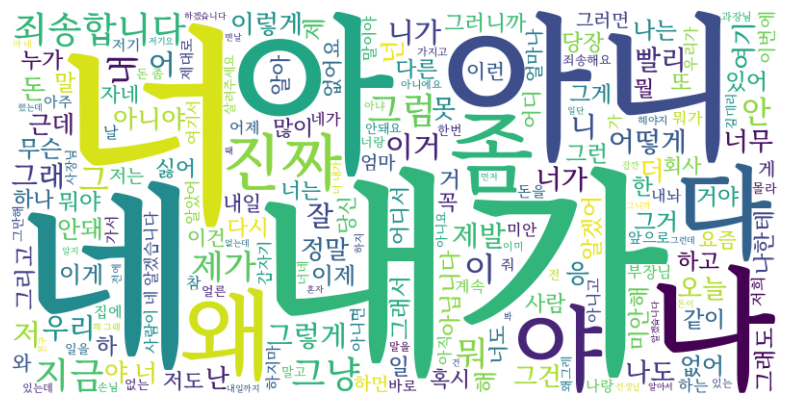

In [31]:
text = ' '.join(data1['conversation'])

font_path = './MaruBuri-SemiBold.ttf'
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate(text)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

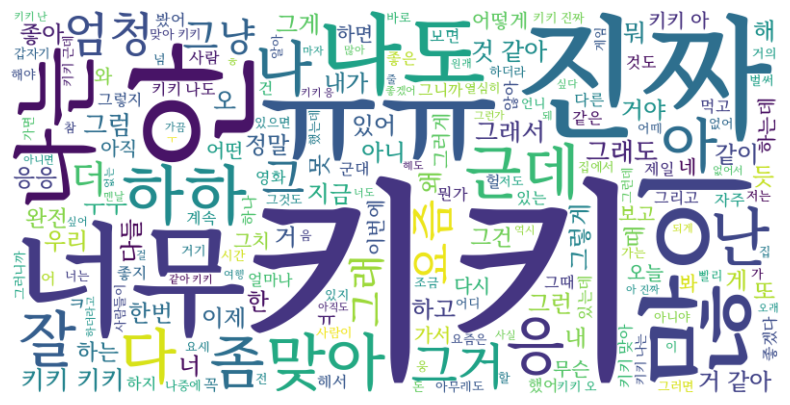

In [15]:
text = ' '.join(data2['conversation'])

font_path = './MaruBuri-SemiBold.ttf'
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate(text)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 모델 학습

In [16]:
model = TFDistilBertForSequenceClassification.from_pretrained(
    'monologg/distilkobert', num_labels=len(label_map))
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  27803904  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
 dropout_10 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 28398341 (108.33 MB)
Trainable params: 28398341 (108.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
def build_model(hp):
    model = TFDistilBertForSequenceClassification.from_pretrained(
        'monologg/distilkobert', num_labels=len(label_map))
    for layer in model.distilbert.transformer.layer:
        layer.trainable = False
    
    learning_rate = hp.Choice('learning_rate', values = [1e-5, 2e-5, 3e-5, 5e-5])

    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    metrics = ['accuracy']
    
    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

    return model

In [18]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hyperband',
    project_name='distilbert_tuning'
)

Reloading Tuner from hyperband/distilbert_tuning/tuner0.json


In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 2,
    restore_best_weights = True
)

tuner.search(
    train_dataset,
    validation_data = test_dataset,
    epochs = 20,
    callbacks = [early_stopping]
)

# 최적의 하이퍼파라미터를 사용하여 모델 훈련
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [20]:
history = model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs = 20,
    callbacks = [early_stopping]
)

Epoch 1/20


2024-06-26 09:59:52.919545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-26 09:59:53.048328: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7948b607a0c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-26 09:59:53.048383: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-06-26 09:59:53.060250: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-26 09:59:53.090249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-06-26 09:59:53.273377: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

124/124 [==============================] - 41s 266ms/step - loss: 1.5723 - accuracy: 0.3012 - val_loss: 1.4955 - val_accuracy: 0.4010
Epoch 2/20
124/124 [==============================] - 20s 161ms/step - loss: 1.3882 - accuracy: 0.4051 - val_loss: 1.2893 - val_accuracy: 0.4616
Epoch 3/20
124/124 [==============================] - 20s 161ms/step - loss: 1.1854 - accuracy: 0.4999 - val_loss: 1.1376 - val_accuracy: 0.5333
Epoch 4/20
124/124 [==============================] - 20s 162ms/step - loss: 1.0544 - accuracy: 0.5598 - val_loss: 1.0862 - val_accuracy: 0.5465
Epoch 5/20
124/124 [==============================] - 20s 163ms/step - loss: 0.9590 - accuracy: 0.6144 - val_loss: 1.0027 - val_accuracy: 0.5909
Epoch 6/20
124/124 [==============================] - 20s 163ms/step - loss: 0.8932 - accuracy: 0.6416 - val_loss: 0.9582 - val_accuracy: 0.6101
Epoch 7/20
124/124 [==============================] - 20s 163ms/step - loss: 0.8415 - accuracy: 0.6710 - val_loss: 0.9520 - val_accuracy: 0.6

In [21]:
# 평가
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()
true_labels = test_labels.numpy()

31/31 [==============================] - 3s 59ms/step


In [22]:
print(classification_report(true_labels, predicted_labels, target_names=label_map.keys()))

              precision    recall  f1-score   support

       협박 대화       0.55      0.58      0.57       189
       갈취 대화       0.74      0.45      0.55       193
 직장 내 괴롭힘 대화       0.57      0.77      0.65       192
   기타 괴롭힘 대화       0.56      0.59      0.58       228
       일반 대화       0.97      0.89      0.93       188

    accuracy                           0.65       990
   macro avg       0.68      0.66      0.66       990
weighted avg       0.67      0.65      0.65       990



findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

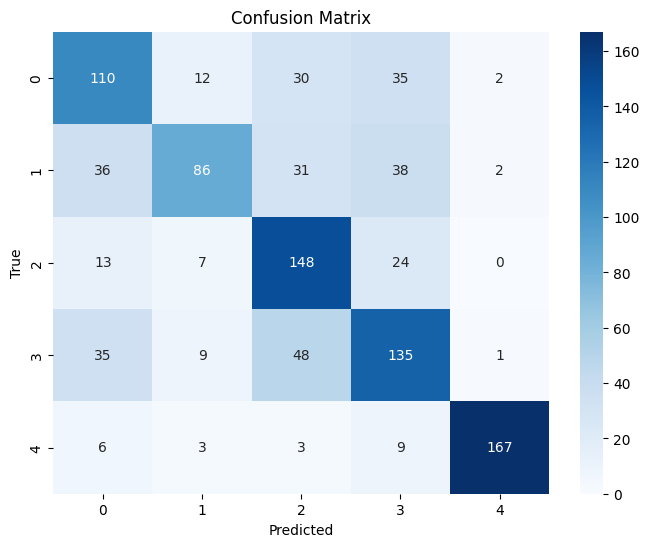

In [30]:
label_map = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}
labels = label_map.values()

cm = confusion_matrix(test_labels, predicted_labels)

# Heatmap으로 confusion matrix 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## kakaobrain kogpt

In [24]:
tokenizer = AutoTokenizer.from_pretrained(
  'kakaobrain/kogpt', revision='KoGPT6B-ryan1.5b-float16',  # or float32 version: revision=KoGPT6B-ryan1.5b
  bos_token='[BOS]', eos_token='[EOS]', unk_token='[UNK]', pad_token='[PAD]', mask_token='[MASK]'
)
model = AutoModelForCausalLM.from_pretrained(
  'kakaobrain/kogpt', revision='KoGPT6B-ryan1.5b-float16',  # or float32 version: revision=KoGPT6B-ryan1.5b
  pad_token_id=tokenizer.eos_token_id,
  torch_dtype='auto', low_cpu_mem_usage=True
).to(device='cuda', non_blocking=True)

/home/ubuntu/work_space/aiffel/dktc_aiffel/.dktc_aiffel/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/kakaobrain/kogpt.
401 Client Error. (Request ID: Root=1-667b6971-22fdf05e3535102d7559e583;763aaa64-47da-418e-85b3-e14c606082ab)

Cannot access gated repo for url https://huggingface.co/kakaobrain/kogpt/resolve/KoGPT6B-ryan1.5b-float16/config.json.
Access to model kakaobrain/kogpt is restricted. You must be authenticated to access it.